In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils import mlp,train_test_model
from utils.scp_utils.scp import SCP
from utils.scp_utils.scp_v2 import SCP as SCP_v2
from utils.ewc_utils.onlineEWC import OnlineEWC
from utils.mas_utils.mas import MAS

from data.sequential_Circles import get_quadrant_circles

## Get Configurations

In [2]:
n_samples=1000
epochs = 500
lr = 1e-3
batch_size = 64 
input_size = 2
hidden_sizes = [256,128]
output_size = 2

num_task = 4
n_slices = 5

activation='Sigmoid'
slope=.1
device='cuda:0'

ewc_alpha=0.5
scp_alpha=0.5
mas_alpha=0.5

gain={
    'Sigmoid':1.,
    'TanH':1.,
    'ReLU':np.sqrt(2.),
    'leakyReLU':np.sqrt(2./(1.+slope**2))
}

In [3]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):        
        torch.nn.init.xavier_uniform_(m.weight,gain=gain[activation])
        if m.bias: 
            torch.nn.init.xavier_uniform_(m.bias,gain=gain[activation])

## Load Dataset

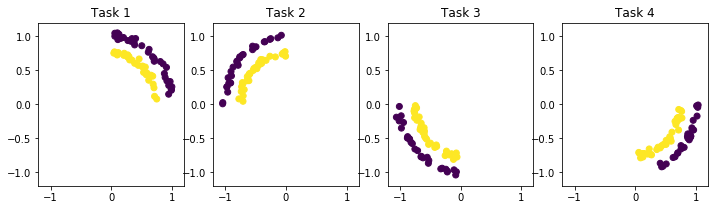

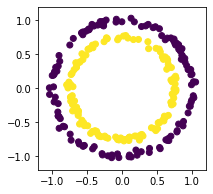

In [4]:
train_loader,test_loader=get_quadrant_circles(n_samples=n_samples,batch_size=batch_size,factor=.75)
fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
titles=['Task 1','Task 2','Task 3', 'Task 4']
for i in range(num_task):
    iter_data=iter(train_loader[i])
    sample,label=iter_data.next()
    ax[i].scatter(sample[:,0],sample[:,1],c=label)
    ax[i].set_xlim([-1.2,1.2])
    ax[i].set_ylim([-1.2,1.2])
    ax[i].set_title(titles[i])
plt.show()

fig,ax =plt.subplots(1,1,figsize=(3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    sample,label=iter_data.next()
    ax.scatter(sample[:,0],sample[:,1],c=label)
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
plt.show()

In [7]:
X,Y=torch.meshgrid(torch.linspace(-1.2,1.2,100),torch.linspace(-1.2,1.2,100))
grid=torch.stack([X.reshape(-1),Y.reshape(-1)]).T

## Vanilla MLP

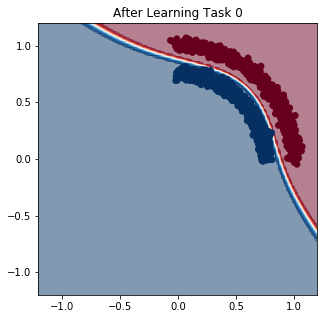

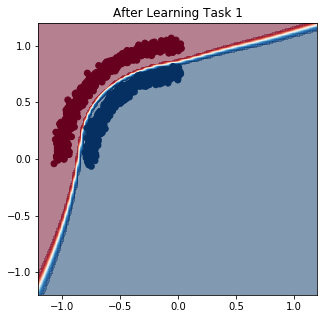

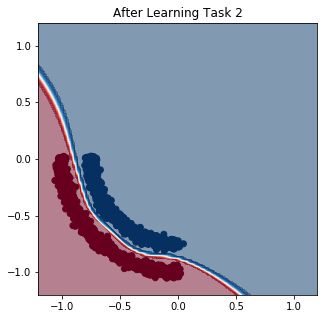

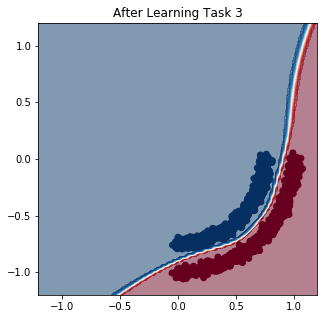

In [8]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device,bias=True).to(device)
# model.apply(weights_init)
## Perform training
loss, acc = {}, {}
for task in tqdm(range(num_task)):
    loss[task] = []
    acc[task] = []
    for _ in tqdm(range(epochs)):
        model.train()
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss[task].append(train_test_model.train_classifier(model=model,
                                                            optimizer=optimizer,
                                                            data_loader=train_loader[task],
                                                            device=device))            
        for sub_task in range(task + 1):
            acc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
    fig=plt.figure(figsize=(5,5))
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    plt.scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.title('After Learning Task %d'%task)
    plt.show()            
        


In [11]:
print(labels)

[0 0 0 ... 1 1 1]


Text(0.5, 0.98, 'Catastrophic forgetting')

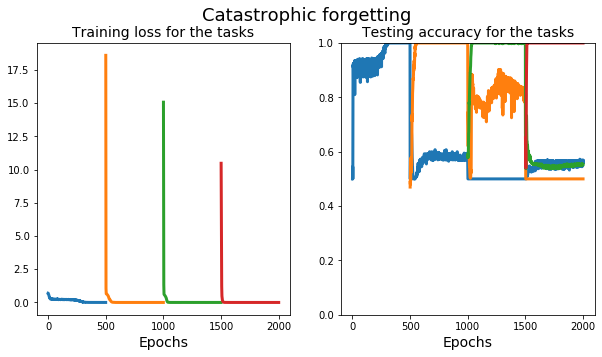

In [7]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the tasks',fontsize=14)
for t, v in acc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the tasks',fontsize=14)
fig.suptitle('Catastrophic forgetting',fontsize=18)

## Test EWC 

0.0


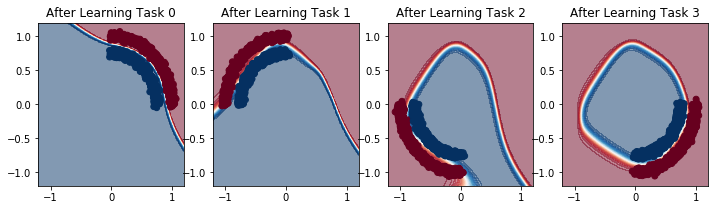

In [105]:
ewc_importance=1e+1

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
# model.apply(weights_init)
ewc= OnlineEWC(model,device=device,alpha=ewc_alpha)
average_importance=0
for i,n in enumerate(ewc._precision_matrices.keys()):
    average_importance+=ewc._precision_matrices[n].detach().cpu().numpy().mean()
average_importance/=i 
print(average_importance)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_ewc, acc_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_ewc[task] = []
    acc_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_ewc[sub_task].append(train_test_model.test_classifier(model=ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    ewc.consolidate(train_loader[task])    
    importance_EWC=list()
    for i,n in enumerate(ewc._precision_matrices.keys()):
        importance_EWC.append(ewc._precision_matrices[n].detach().cpu().numpy())
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
#     fig=plt.figure(figsize=(5,5))
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    ax[task].scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    ax[task].set_xlim(-1.2,1.2)
    ax[task].set_ylim(-1.2,1.2)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using EWC Regularizer')

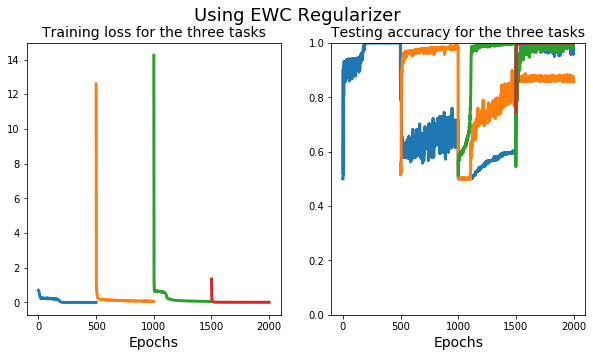

In [106]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using EWC Regularizer',fontsize=18)

## Test SketchEWC 

In [22]:
from utils.ewc_utils.sketchEWC import SketchEWC

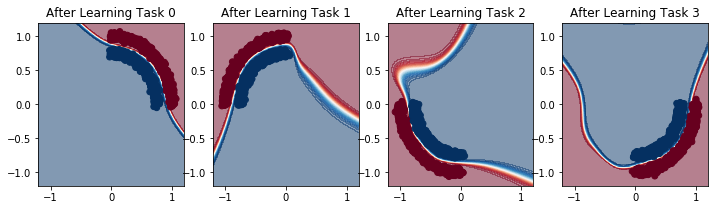

In [79]:
sketch_ewc_importance=1e4

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
# model.apply(weights_init)
sketch_ewc= SketchEWC(model,device=device,alpha=0.5,n_bucket=50)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_sketch_ewc, acc_sketch_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_ewc[task] = []
    acc_sketch_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=sketch_ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=sketch_ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_sketch_ewc[sub_task].append(train_test_model.test_classifier(model=sketch_ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    sketch_ewc.consolidate(train_loader[task])    
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    ax[task].scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    ax[task].set_xlim(-1.2,1.2)
    ax[task].set_ylim(-1.2,1.2)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using SketchEWC Regularizer')

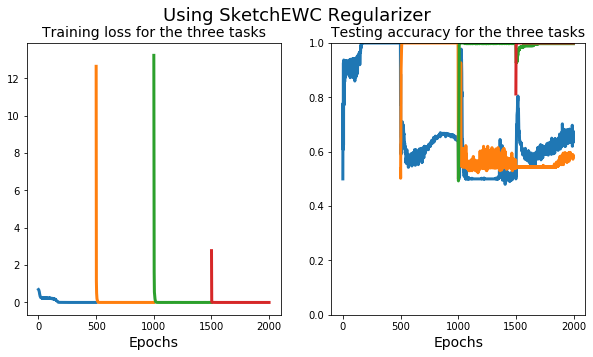

In [78]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_sketch_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SketchEWC Regularizer',fontsize=18)

## Testing MAS

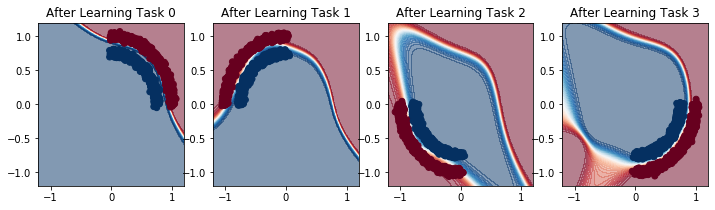

In [107]:
mas_importance=1e+2
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)

mas= MAS(model,device=device,alpha=mas_alpha)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_mas, acc_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_mas[task] = []
    acc_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_mas[task].append(train_test_model.mas_train_classifier(mas=mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_mas[sub_task].append(train_test_model.test_classifier(model=mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    mas.consolidate(train_loader[task])    
#     torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
    
    importance_MAS=list()
    for i,n in enumerate(mas._precision_matrices.keys()):
        importance_MAS.append(mas._precision_matrices[n].detach().cpu().numpy())
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    ax[task].scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    ax[task].set_xlim(-1.2,1.2)
    ax[task].set_ylim(-1.2,1.2)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


In [12]:
# for f in importance_MAS:
#     plt.hist(np.log10(f.reshape(-1)+1e-12),bins=100)
#     plt.show()

Text(0.5, 0.98, 'Using MAS Regularizer')

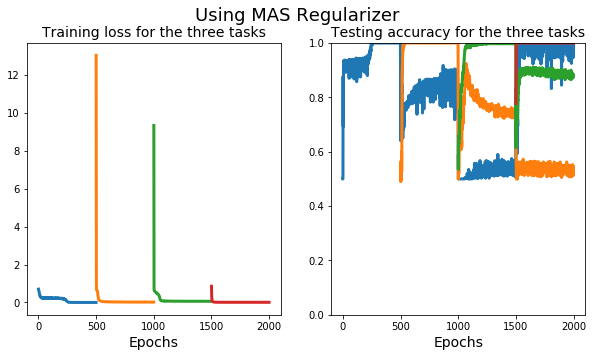

In [108]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using MAS Regularizer',fontsize=18)

In [109]:
def calculate_FIM(model: nn.Module, 
                  data_loader: torch.utils.data.DataLoader):
    
    device=model.device
    model.eval()
    grad=[]
    for n, p in model.named_parameters():
        grad.append(p.grad.data.view(-1))            
    grad=torch.cat(grad)
    d=grad.shape[0]
    A=torch.zeros((d,d))
        
    for i,(imgs,labels) in tqdm(enumerate(data_loader)):
        model.zero_grad() # Zero the gradients
        imgs,labels = imgs.to(device),labels.to(device)# Get Inout

        loss=nn.CrossEntropyLoss()(model(imgs).to(device),labels.to(device))
        loss.backward()
        
        grad=[]
        for n, p in model.named_parameters():
            grad.append(p.grad.data.view(-1))            
        grad=torch.cat(grad).cpu()
        A+=torch.matmul(grad.unsqueeze(1).cpu(),grad.unsqueeze(0).cpu())
    A=A/float(i+1)
    return A

In [110]:
A=calculate_FIM(model=model,data_loader=train_loader[task])

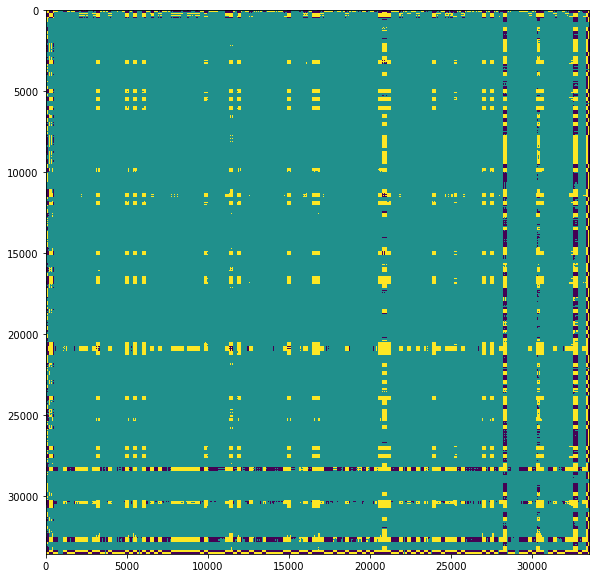

In [118]:
B=A.clone()
vis_thresh=1e-10
B=np.sign(B)*(abs(B)>vis_thresh)
fig=plt.figure(figsize=(10,10))
# osetx=50000
# osety=osetx
# plt.imshow(B[osetx:-1,osety:-1])
plt.imshow(B)

In [120]:
from utils.mas_utils.fullMAS import FullMAS

RuntimeError: CUDA out of memory. Tried to allocate 4.19 GiB (GPU 0; 11.00 GiB total capacity; 8.40 GiB already allocated; 1.07 GiB free; 8.43 GiB reserved in total by PyTorch)

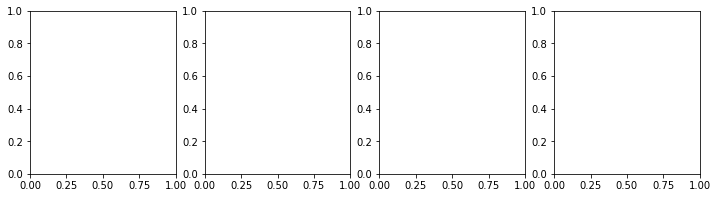

In [126]:
full_mas_importance=1e+4
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)

full_mas= FullMAS(model,device=device,alpha=0.5)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_full_mas, acc_full_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_full_mas[task] = []
    acc_full_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_full_mas[task].append(train_test_model.mas_train_classifier(mas=full_mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=full_mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_full_mas[sub_task].append(train_test_model.test_classifier(model=full_mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    full_mas.consolidate(train_loader[task])    
#     torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
       
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    ax[task].scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    ax[task].set_xlim(-1.2,1.2)
    ax[task].set_ylim(-1.2,1.2)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


In [70]:
from utils.mas_utils.sketchMAS import SketchMAS

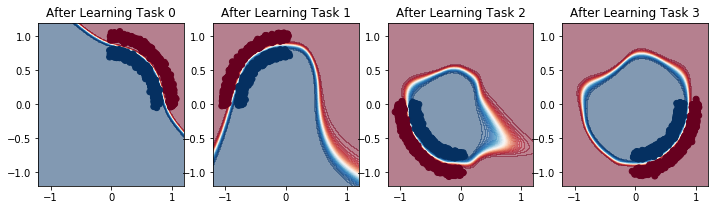

In [98]:
sketch_mas_importance=1e+4
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)

sketch_mas= SketchMAS(model,device=device,alpha=0.5,n_bucket=50)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_sketch_mas, acc_sketch_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_mas[task] = []
    acc_sketch_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_mas[task].append(train_test_model.mas_train_classifier(mas=sketch_mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=sketch_mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_sketch_mas[sub_task].append(train_test_model.test_classifier(model=sketch_mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    sketch_mas.consolidate(train_loader[task])    
#     torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
       
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    ax[task].scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    ax[task].set_xlim(-1.2,1.2)
    ax[task].set_ylim(-1.2,1.2)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using SketchMAS Regularizer')

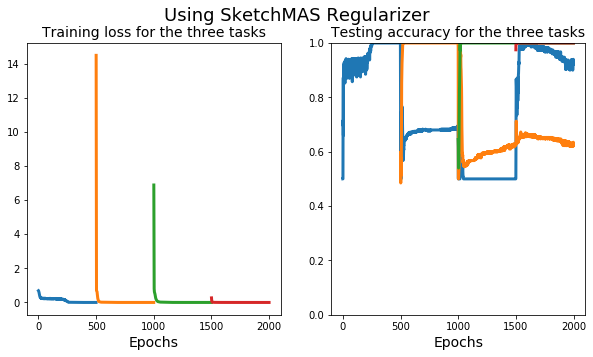

In [100]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_sketch_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SketchMAS Regularizer',fontsize=18)

## SCP

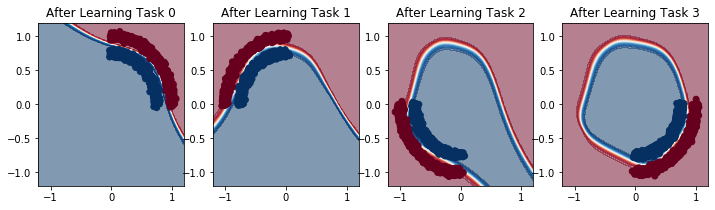

In [96]:
scp_importance=1e+1
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
scp= SCP(model,device=device,alpha=scp_alpha,n_slices=n_slices)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_scp, acc_scp = {}, {}
for task in tqdm(range(num_task)):
    loss_scp[task] = []
    acc_scp[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_scp[task].append(train_test_model.scp_train_classifier(scp=scp,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=scp_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_scp[sub_task].append(train_test_model.test_classifier(model=scp.model,
                                                                     data_loader=test_loader[sub_task],
                                                                     device=device))            
    scp.consolidate(train_loader[task])    
#     torch.save(scp.model.state_dict(), 'saved_models/model_scp_'+str(task)+'.pt') 
    
    importance_SCP=list()
    for i,n in enumerate(scp._precision_matrices.keys()):
        importance_SCP.append(scp._precision_matrices[n].detach().cpu().numpy())
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(100,100).detach().cpu().numpy()
    samples=train_loader[task].dataset.data.detach().cpu().numpy()
    labels=train_loader[task].dataset.targets.detach().cpu().numpy()
#     fig=plt.figure(figsize=(5,5))
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    ax[task].scatter(samples[:,0],samples[:,1],c=labels,cmap='RdBu')
    ax[task].set_xlim(-1.2,1.2)
    ax[task].set_ylim(-1.2,1.2)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using SCP Regularizer')

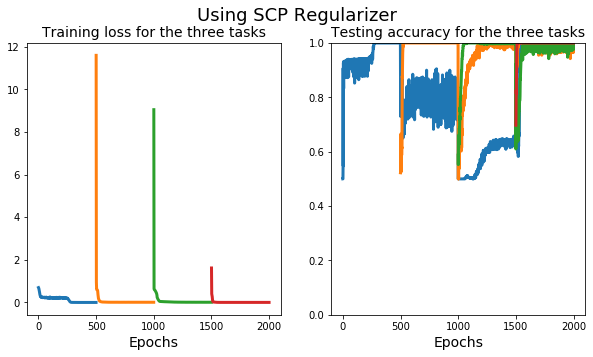

In [97]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SCP Regularizer',fontsize=18)

In [16]:
def get_mean_acc(acc,epochs):
    num_task=len(acc)
    temp=np.zeros((num_task,len(acc[0])))
    for t,v in acc.items():
        temp[t,range(t * epochs, num_task * epochs)]=v
        if t<num_task-1:
            temp[t+1,:]=temp[:t+1,:].mean(0)
    return temp.mean(0)

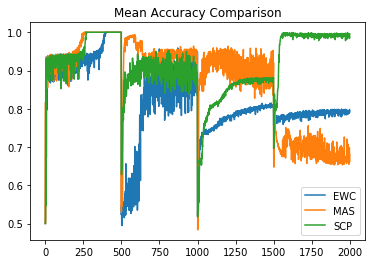

In [99]:
plt.plot(get_mean_acc(acc_ewc,epochs))
plt.plot(get_mean_acc(acc_mas,epochs))
plt.plot(get_mean_acc(acc_scp,epochs))
plt.title('Mean Accuracy Comparison')
plt.legend(['EWC','MAS','SCP'])